# Neo4J Import and Queries

In [1]:
pip install neo4j==4.4.11

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for neo4j: filename=neo4j-4.4.11-py3-none-any.whl size=111249 sha256=51eb54a20e5e8132082d0b2ba16d04a15823968eb851b7f64ff450b46941316b
  Stored in directory: /home/jovyan/.cache/pip/wheels/9b/29/51/cd9c7f08102e1afefd87d7307e45556c08f51eec519f2e6e05
Successfully built neo4j
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import random
import csv

## Aufbau der Datenbankverbindung

In [3]:
from neo4j import GraphDatabase
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response

Der Variablen "conn" sollte der LEADER-Knoten zugewiesen werden, der WRITE-Rechte hat.
Um herauszufinden, welcher Knoten der LEADER-Knoten ist, sollte zu der Webkonsole eines Knotens unter http://localhost:7474 verbunden werden und dann der Befehl ":sysinfo" ausgeführt werden. 

Es sollte eine Tabelle folgender Art erscheinen:

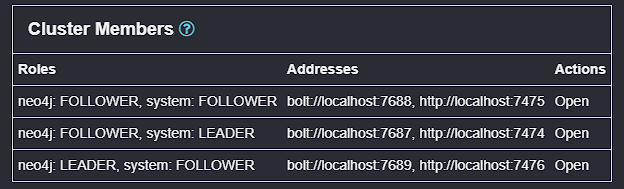


core1: bolt://localhost:7687, http://localhost:7474
core2: bolt://localhost:7688, http://localhost:7475
core3: bolt://localhost:7689, http://localhost:7476

Der Knoten, beim dem "neo4j:LEADER" steht, sollte unten eingetragen werden. Als Port wird allerdings immer "7687" auf der Host-Maschine verwendet.

In [4]:
conn = Neo4jConnection(uri="bolt://core3:7687", user="neo4j", pwd="password")
secondConn = Neo4jConnection(uri="bolt://core2:7687", user="neo4j", pwd="password")

In [5]:
print(conn.query(f"MATCH (n) RETURN n LIMIT 1;"))

print(secondConn.query(f"MATCH (n) RETURN n LIMIT 1;"))

[]
[]


## Importieren der Knoten und Beziehungen

### Einlesen des "twitter_combined" Files

In [6]:
follows_file = open('twitter_combined.txt', 'r')
lines = follows_file.readlines()

follows = []
users = set()
for line in lines:
    line = line.replace('\n','')
    id1, id2 = line.split(' ')
    users.add(id1)
    users.add(id2)
    follows.append([id1, id2])

### Erstellung des CSV Files für den Import der User

In [7]:
count = 0
f = open("import/users.csv", "w")
f.write("userId,name,:Label\n")
for user in users:
    f.write(user + ",user" + str(count) + ",USER\n")
    count += 1
f.close()

### Importieren der User

In [8]:
%%time
conn.query("LOAD CSV WITH HEADERS FROM 'file:///users.csv' AS row CREATE (:User {userId: row.userId, name: row.name})")
conn.query("CREATE CONSTRAINT user_constraint IF NOT EXISTS FOR (u:User) REQUIRE u.userId IS UNIQUE")

CPU times: user 2.05 ms, sys: 522 µs, total: 2.58 ms
Wall time: 3.92 s


[]

In [9]:
print(conn.query("MATCH(u: User) return u LIMIT 10"));
print(secondConn.query("MATCH(u: User) return u LIMIT 10"))

[<Record u=<Node id=0 labels=frozenset({'User'}) properties={'name': 'user0', 'userId': '21446951'}>>, <Record u=<Node id=1 labels=frozenset({'User'}) properties={'name': 'user1', 'userId': '5877282'}>>, <Record u=<Node id=2 labels=frozenset({'User'}) properties={'name': 'user2', 'userId': '210629559'}>>, <Record u=<Node id=3 labels=frozenset({'User'}) properties={'name': 'user3', 'userId': '16910033'}>>, <Record u=<Node id=4 labels=frozenset({'User'}) properties={'name': 'user4', 'userId': '263908010'}>>, <Record u=<Node id=5 labels=frozenset({'User'}) properties={'name': 'user5', 'userId': '54325840'}>>, <Record u=<Node id=6 labels=frozenset({'User'}) properties={'name': 'user6', 'userId': '40341175'}>>, <Record u=<Node id=7 labels=frozenset({'User'}) properties={'name': 'user7', 'userId': '6016612'}>>, <Record u=<Node id=8 labels=frozenset({'User'}) properties={'name': 'user8', 'userId': '35833912'}>>, <Record u=<Node id=9 labels=frozenset({'User'}) properties={'name': 'user9', 'use

### Erstellung des CSV Files für den Import der Tweets anhand des "tweets" CSV Files 

In [10]:
tweets = pd.read_csv("tweets.csv")
f = open("import/tweetsDB.csv", "w")
writer = csv.writer(f)
writer.writerow(["tweetId","content","date_time","language",":Label"])
count = 1
for index, tweet in tweets.iterrows():
    writer.writerow([count,tweet["content"],tweet["date_time"],tweet["language"],"TWEET"])
    count += 1
f.close()

### Importieren der Tweets

In [11]:
%%time
conn.query("LOAD CSV WITH HEADERS FROM 'file:///tweetsDB.csv' AS row CREATE (:Tweet {tweetId: row.tweetId, content: row.content, date_time: row.date_time, language: row.language})")
conn.query("CREATE CONSTRAINT tweet_constraint IF NOT EXISTS FOR (t:Tweet) REQUIRE t.tweetId IS UNIQUE")

CPU times: user 2.57 ms, sys: 407 µs, total: 2.97 ms
Wall time: 2.71 s


[]

### Erstellung des CSV Files für den Import der FOLLOWS-Beziehung

In [12]:
f = open("import/follows.csv", "w")
f.write("userId,followerId,:TYPE\n")
for follow in follows:
    f.write(follow[0] + "," + follow[1] + ",FOLLOWS\n")
f.close()

### Import der FOLLOWS-Beziehungen

In [13]:
%%time
conn.query("LOAD CSV WITH HEADERS FROM 'file:///follows.csv' AS row MATCH (e:User {userId: row.userId}) MATCH (c:User {userId: row.followerId}) MERGE (e)-[:FOLLOWS]->(c)")

Failed to read from defunct connection IPv4Address(('core3', 7687)) (IPv4Address(('178.201.0.4', 7687)))


Query failed: Failed to read from defunct connection IPv4Address(('core3', 7687)) (IPv4Address(('178.201.0.4', 7687)))
CPU times: user 5.68 ms, sys: 7.71 ms, total: 13.4 ms
Wall time: 1min 3s


### Erstellung des CSV Files für den Import der POSTED-Beziehung
Jeder der Tweets wird zufällig auf einen der 100 User mit den meisten Followern verteilt.

In [14]:
top100 = conn.query("MATCH (a)-[:FOLLOWS]->(b) RETURN b, COUNT(a) as followers ORDER BY followers DESC LIMIT 100")

Query failed: Couldn't connect to core3:7687 (resolved to ('178.201.0.4:7687',)):
Failed to establish connection to ResolvedIPv4Address(('178.201.0.4', 7687)) (reason [Errno 111] Connection refused)


In [15]:
user_ids = []
for record in top100:
    user_ids.append(record.get("b").get("userId"))

tweets = pd.read_csv("import/tweetsDB.csv")
f = open("import/posted.csv", "w")
f.write("userId,tweetId,:TYPE\n")
for index, tweet in tweets.iterrows():
    f.write(f'{random.choice(user_ids)},{tweet["tweetId"]},POSTED\n')
f.close()

TypeError: 'NoneType' object is not iterable

### Import der POSTED-Beziehungen

In [ ]:
%%time
conn.query("LOAD CSV WITH HEADERS FROM 'file:///posted.csv' AS row MATCH (u:User {userId: row.userId}) MATCH (t:Tweet {tweetId: row.tweetId}) MERGE (u)-[:POSTED]->(t)")

### Erstellung des CSV Files für den Import der LIKES-Beziehung
Für jeden Tweet werden aus den Followern des Posters etwa 10 % ausgewählt, welche des Post liken. Die Like-Zahlen aus dem "tweets" CSV File werden dabei nicht berücksichtigt.

In [ ]:
allTweets = conn.query("Match (t: Tweet) RETURN t");
f = open("import/likes.csv","w")
f.write("userId,tweetId,:TYPE\n")

for user in top100: 
    followers = conn.query(f"MATCH (follower:User)-[:FOLLOWS]->(following:User) WHERE following.userId ='{user['b']['userId']}' RETURN follower")
    tweets = conn.query(f"MATCH (u:User {{userId: '{user['b']['userId']}'}})-[:POSTED]->(t:Tweet) RETURN t");
    for tweet in tweets: 
        for follower in followers:
            shouldLike = random.random() < 0.1
            if shouldLike:
                f.write(f"{follower['follower']['userId']},{tweet['t']['tweetId']},LIKES\n")

f.close()    

### Import der LIKES-Beziehungen

In [ ]:
%%time
conn.query("LOAD CSV WITH HEADERS FROM 'file:///likes.csv' as row CALL { with row MATCH (u:User {userId: row.userId}) MATCH (t:Tweet {tweetId: row.tweetId}) MERGE (u)-[:LIKES]->(t) }  IN TRANSACTIONS OF 100000 ROWS")

## Queries

### 1. Alle Posts eines zufälligen Users

In [ ]:
random_poster = random.choice(top100)

result = conn.query(f"MATCH (u:User {{name: '{random_poster['b']['name']}'}})-[:POSTED]->(t:Tweet) RETURN t")
for tweet in result:
    print(tweet['t']['content'])
    print("")

### 2. Top 100 User mit den meisten Followern

In [ ]:
top100 = conn.query("MATCH (a)-[:FOLLOWS]->(b) RETURN b, COUNT(a) as followers ORDER BY followers DESC LIMIT 100")

for user in top100:
    print(user['b']['name'], "hat", user['followers'], "Follower")

### 3. Top 100 User, die den meisten Usern der Top 100 folgen

In [ ]:
query = """MATCH (follower:User)-[follows:FOLLOWS]->(followed:User)
WHERE followed.userId IN [""" 

count = 0
for user in top100:
    query += f"'{user['b']['userId']}'"
    if count < 99: query += ","
    count += 1

query += """]
WITH follower, COUNT(follows) AS numFollowed
ORDER BY numFollowed DESC
RETURN follower.name AS username, numFollowed
LIMIT 100
"""

result = conn.query(query)

In [ ]:
for record in result:
    print(record['username'], "folgt", record['numFollowed'], 'Usern')

### 4. Informationen für persönliche Startseite eines zufälligen Users (der Top 100 mit den meisten Followern)

In [ ]:
random_user = random.choice(top100)

#### 1. Anzahl der Follower

In [ ]:
result = conn.query(f"MATCH (follower:User)-[:FOLLOWS]->(user:User {{name: '{random_user['b']['name']}'}}) RETURN count(follower) AS followerCount")
print(result[0]['followerCount'])

#### 2. Anzahl der verfolgten Accounts

In [ ]:
result = conn.query(f"MATCH (user:User {{name: '{random_user['b']['name']}'}})-[:FOLLOWS]->(followed:User) RETURN count(followed) AS followedCount")
print(result[0]['followedCount'])

#### 3.1 Die 25 meistgeliketen Posts der verfolgten Accounts

In [ ]:
result = conn.query(f"""
MATCH (follower:User)-[:FOLLOWS]->(followed:User)-[:POSTED]->(tweet:Tweet)
WHERE follower.name = '{random_user['b']['name']}'
WITH follower, collect(followed.name) AS followedUsers
MATCH (t:Tweet)<-[:POSTED]-(u:User)
WHERE u.name IN followedUsers
OPTIONAL MATCH (t)<-[:LIKES]-(liker:User)
RETURN t.content AS content, COUNT(liker) AS numLikes
ORDER BY numLikes DESC
LIMIT 25
""")

for tweet in result:
    print(tweet['content'])
    print("Likes: ", tweet['numLikes'])
    print()

#### 3.2 Die 25 neuesten Posts der verfolgten Accounts

In [ ]:
result = conn.query(f"""
MATCH (follower:User)-[:FOLLOWS]->(followed:User)-[:POSTED]->(tweet:Tweet)
WHERE follower.name = '{random_user['b']['name']}'
WITH follower, collect(followed.name) AS followedUsers
MATCH (t:Tweet)<-[:POSTED]-(u:User)
WHERE u.name IN followedUsers
RETURN t.content AS content, t.date_time AS date
ORDER BY t.date_time DESC
LIMIT 25
""")

for tweet in result:
    print(tweet['content'])
    print("Getweeted am: ", tweet['date'])
    print()

#### 4. Erstellung eines neuen Posts: Herstellen einer Caching-Beziehung bei allen Followern

In [ ]:
num_tweets = conn.query("MATCH (t:Tweet) RETURN COUNT(t)")[0]['COUNT(t)']
print(num_tweets)

In [ ]:
tweet = {
    "tweetId": str(num_tweets+1),
    "content": "Doing neo4j queries right now #BDEA",
    "date_time": "18/06/2023 09:48",
    "language": "en"
}

##### Tweet importieren

In [ ]:
new_tweet = conn.query(f"CREATE (t:Tweet {{tweetId: '{tweet['tweetId']}', content: '{tweet['content']}', date_time: '{tweet['date_time']}', language: '{tweet['language']}'}}) RETURN t")

In [ ]:
print(new_tweet)

##### POSTED-Beziehung herstellen

In [ ]:
conn.query(f"MATCH (user:User {{userId: '{random_user['b']['userId']}'}}) MATCH (tweet:Tweet {{tweetId: '{new_tweet[0]['t']['tweetId']}'}}) CREATE (user)-[:POSTED]->(tweet)")

##### CACHED-Beziehung bei allen Followern des Posters herstellen

In [ ]:
followers = conn.query(f"MATCH (follower:User)-[:FOLLOWS]->(user:User {{userId: '{random_user['b']['userId']}'}}) RETURN follower")
print(len(followers))

In [ ]:
print(random_user['b']['userId'])

In [ ]:
for follower in followers:
    conn.query(f"MATCH (user:User {{userId: '{follower['follower']['userId']}'}}) MATCH (tweet:Tweet {{tweetId: '{new_tweet[0]['t']['tweetId']}'}}) CREATE (user)-[:CACHED]->(tweet)")

##### Check how many users have the tweet cached (should be the same as number followers)

In [ ]:
conn.query("MATCH (u:User)-[r:CACHED]->(tweet:Tweet {tweetId: '52543'}) RETURN COUNT(u)")

#### 5. Die 25 beliebtesten Tweets, welche die Wörter "hello" und "from" enthalten

In [ ]:
result = conn.query("""
MATCH (t:Tweet)
WHERE ALL(word IN [' hello ', ' from '] WHERE t.content CONTAINS word)
WITH t
MATCH (t)<-[:LIKES]-(liker:User)
RETURN t.content AS content, COUNT(liker) AS numLikes
ORDER BY numLikes DESC
LIMIT 25
""")

for tweet in result:
    print(tweet['content'])
    print("Likes: ", tweet['numLikes'])
    print()